In [1]:
%load_ext autoreload
%autoreload 2

**IMPORTANT**: matplotlib widget requires:
`ipympl` installed in kernel environment with a compatible version to jupyterlab server environment.
See: https://matplotlib.org/ipympl/installing.html

In particular, if slider widgets do not appear, or an error about widgets is returned.

In [2]:
%matplotlib widget

In [3]:
#%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
from datetime import datetime, timedelta
from ipywidgets import interact
# from datetime import datetime as dt, time, timedelta

In [52]:
import sys
import os
from os.path import join
import re
#import cv2

from tqdm.notebook import tqdm
for i in tqdm(range(50)): pass # Test progress bar tqdm

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# If drawing the video frames (else, not needed)
from decord import VideoReader
from decord import cpu, gpu
import ipywidgets
import PIL

In [5]:
# Try to import plotbee from local git clone
# Alternative would be: 
# cd .../plotbee
# pip install -e .   (install local directory editable mode)
module_path = os.path.abspath(os.path.join('..'))
print(f'ADDING "{module_path}" to path for import')
sys.path.insert(0,module_path)
#sys.path.remove('/mnt/storage/work/rmegret/plotbee')
print('PATH=',sys.path)

ADDING "/home/rmegret/plotbee" to path for import
PATH= ['/home/rmegret/plotbee', '/home/rmegret/miniforge3/envs/events/lib/python312.zip', '/home/rmegret/miniforge3/envs/events/lib/python3.12', '/home/rmegret/miniforge3/envs/events/lib/python3.12/lib-dynload', '', '/home/rmegret/miniforge3/envs/events/lib/python3.12/site-packages']


In [6]:
from plotbee.beevideoutil import labelbee_convert as lb
from plotbee.beevideoutil import video as bv
import plotbee
print(f'plotbee imported from "{plotbee.__file__}"')

plotbee imported from "/home/rmegret/plotbee/plotbee/__init__.py"


/home/rmegret/plotbee/plotbee/beevideoutil/labelbee_convert.py:319: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load ready-made event dataframe

In [8]:
full_df = pd.read_parquet('one_week_analysis_800__tracks__with_labelbee_videoid.parquet')

In [9]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958893 entries, 0 to 1958892
Data columns (total 27 columns):
 #   Column              Dtype         
---  ------              -----         
 0   track_id            int64         
 1   track_pollen_score  float64       
 2   track_shape         object        
 3   track_event         object        
 4   track_tagid         float64       
 5   track_hastag        bool          
 6   track_startframe    int64         
 7   track_startx        int64         
 8   track_starty        int64         
 9   track_starta        float64       
 10  track_endframe      int64         
 11  track_endx          int64         
 12  track_endy          int64         
 13  track_enda          float64       
 14  track_length        int64         
 15  datetime            datetime64[us]
 16  track_starttime     datetime64[us]
 17  track_endtime       datetime64[us]
 18  pollen              bool          
 19  entering            bool          
 20  le

In [10]:
full_df.track_shape.unique()

array(['inside', 'ramp-inside', 'outside_inside', 'ramp_ramp', 'noise',
       'inside_ramp', 'ramp_outside', 'outside_ramp', 'outside',
       'inside_out', 'outside_outside', 'inside_inside', None],
      dtype=object)

# Display event chronogram

## Select which tagids to display

In [11]:
# Select tag ids that have 5 events or more
id_counts = full_df['track_tagid'].dropna().astype(int).value_counts().rename('counts')
tids = id_counts[id_counts>=5].index
tids = np.sort(tids).astype(int)
tids

array([ 197,  508,  515,  516,  517,  638,  661,  677,  930,  986, 1109,
       1230, 1237, 1361, 1404, 1407, 1415, 1607, 1609, 1621, 1651, 1652,
       1698, 1722, 1780, 1786, 1797, 1900, 1979, 2258, 2487])

In [12]:
# Custom tids
#tids = np.array([1609,1621],dtype=int)

In [13]:
# Restrict data to selected tids
vdf = full_df[full_df.track_tagid.isin(tids)].copy()
vdf['track_tagid'] = vdf['track_tagid'].astype(int)
vdf.shape

(5024, 27)

## Simple inline plot

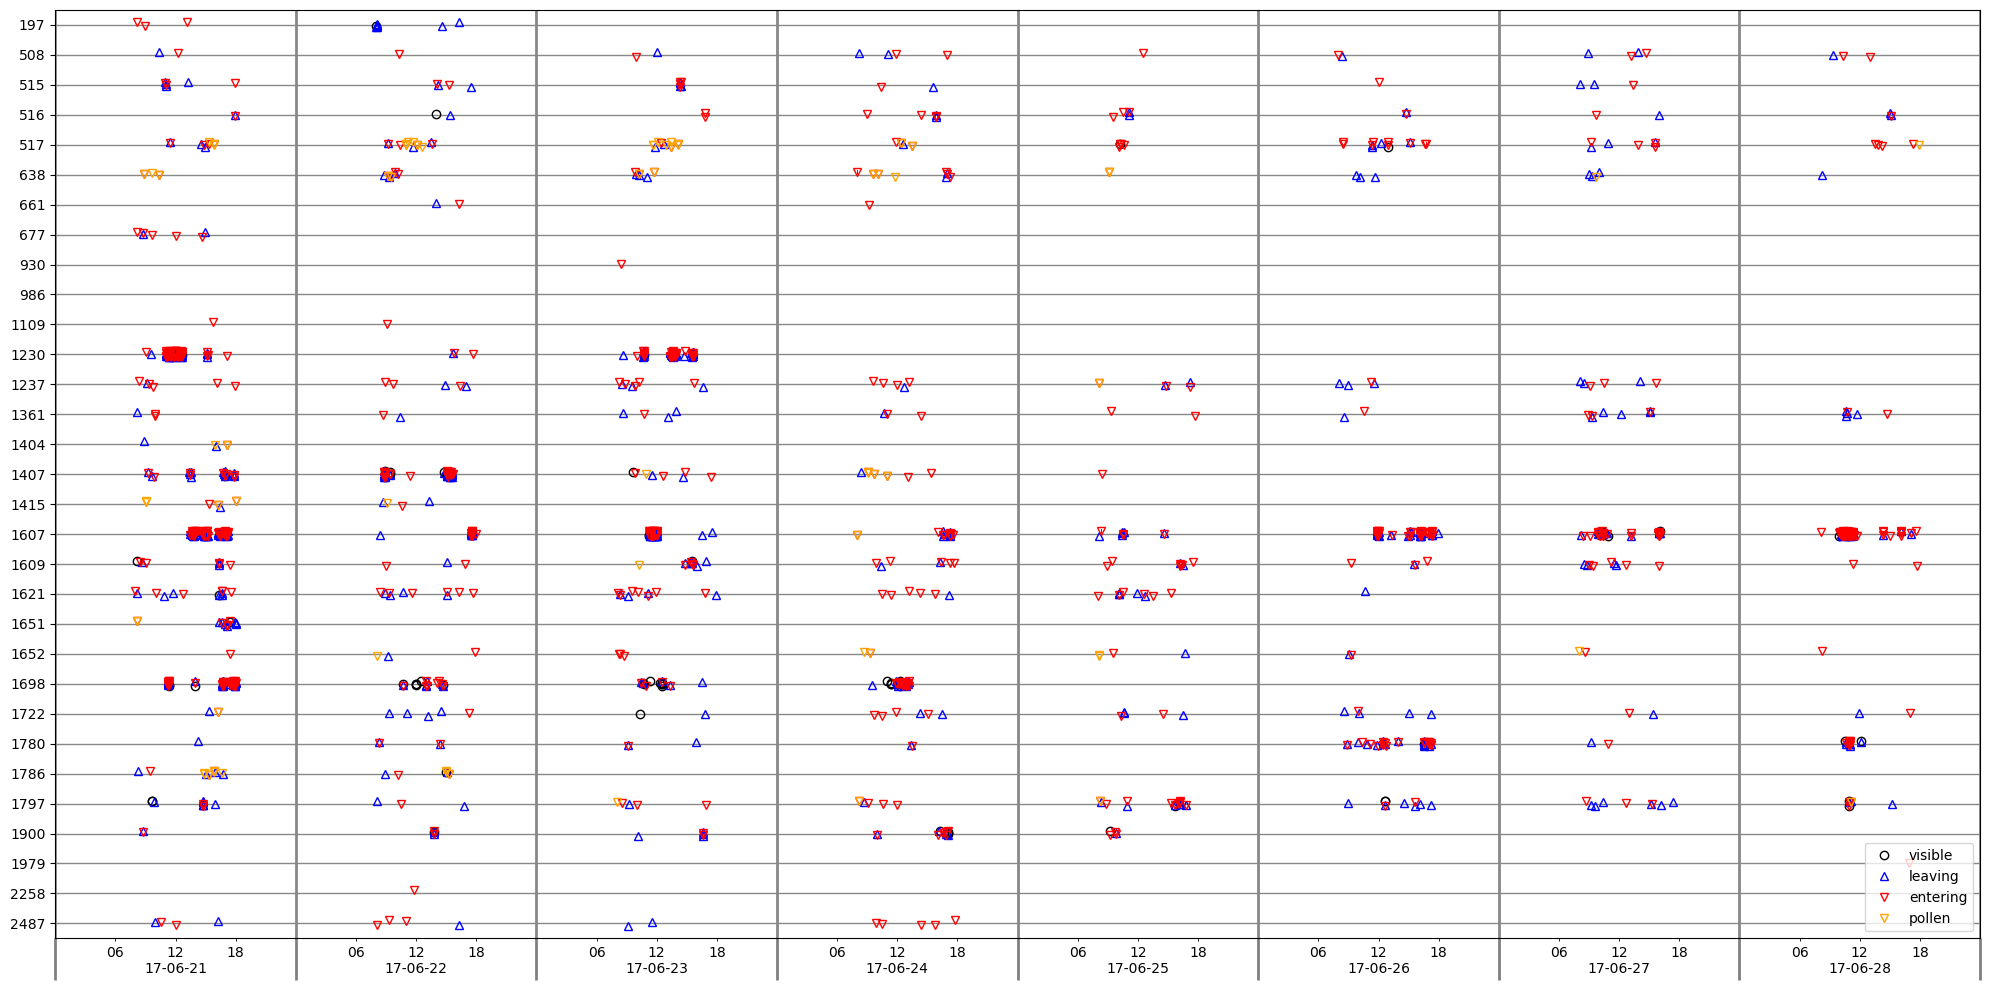

In [14]:
%matplotlib inline
from datetime import datetime as dt

fig,axes = plt.subplots(1,1,figsize=(20,10))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.tight_layout();

lb.format_multiday()
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))

plt.tight_layout();

plt.savefig("tagged_bees_activities.png")

## Widget based event plot (with click callback)

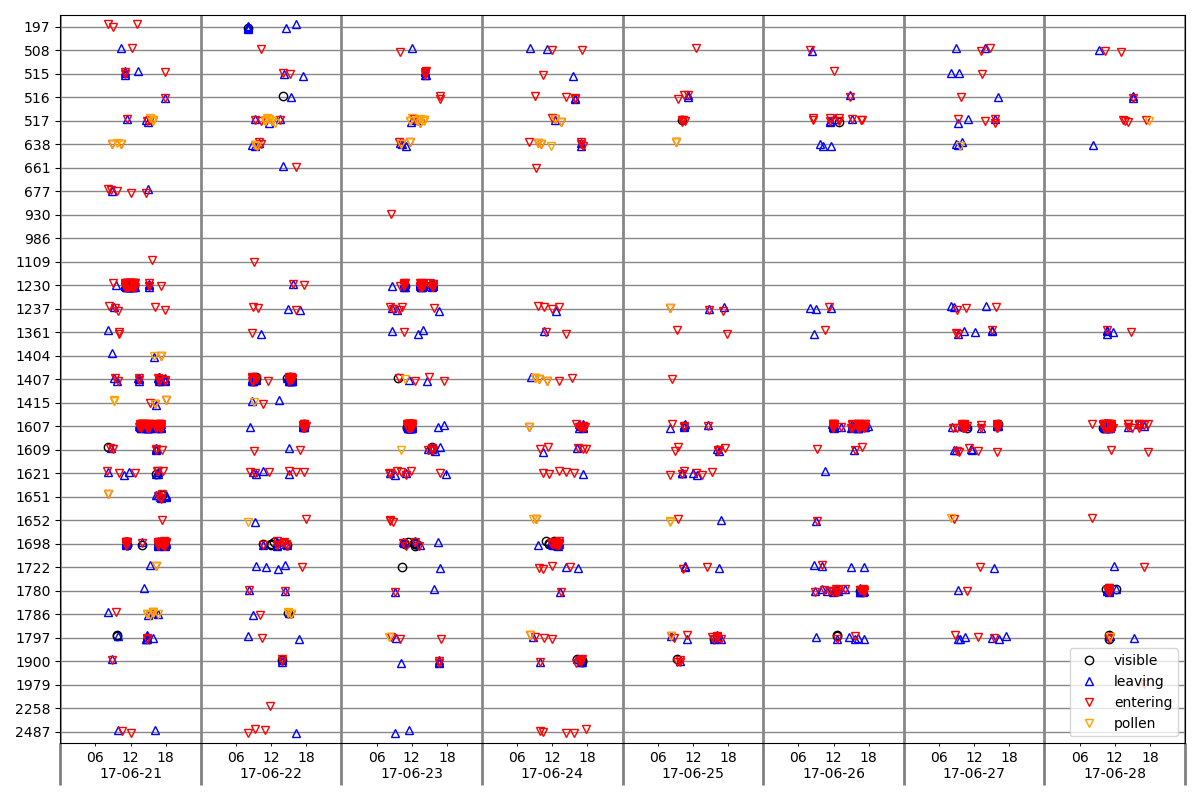

In [17]:
%matplotlib widget
from datetime import datetime as dt
from matplotlib.dates import num2date

fig,axes = plt.subplots(1,1,figsize=(12,8))
plt.sca(axes)
lb.plot_activities_df(vdf, plot_interval=True, tagids=None, leaving_symbol = '^', entering_symbol = 'v');
plt.xlim(pd.to_datetime('2017-06-21 00:00'),pd.to_datetime('2017-06-29 00:00'))
lb.format_multiday()
plt.tight_layout();

#saveme={}

def on_click(event):
    print('On_click',event)
    #saveme['event']=event
    
    # CONVERT RAW COORDINATES X,Y INTO DATETIME AND ID
    x,y = event.xdata, event.ydata
    #ts = num2date(x, tz=None)
    ts = pd.Timestamp(num2date(x)).tz_localize(None)  # avoid error "Cannot compare tz-naive and tz-aware datetime-like objects"
    ry = round(y)
    ids = axes.activity_data_['ids']
    if ( (ry>=0) and (ry < len(ids)) ):
        tagid = ids[ry]
    else:
        tagid = None
    print("ID=",tagid,"date=",ts)
    if (id is None):
        return
    
    # FIND CLOSEST EVENT FOR SELECTED ID
    # https://stackoverflow.com/questions/42264848/pandas-dataframe-how-to-query-the-closest-datetime-index
    ddf0 = vdf[vdf.track_tagid==tagid]
    ddf0 = ddf0[ ddf0.entering | ddf0.leaving | ddf0.pollen ]   # Keep only specific types of events
    #ddf = ddf0.set_index('track_starttime')
    #iloc0_idx = ddf.index.get_indexer([ts], method='nearest')
    #iloc0_idx = ddf0['track_starttime'].searchsorted(ts)
    # if (iloc0_idx==ddf0.shape[0]):
    #     print('ABORT, did not find close date')
    #     return
    iloc0_idx = (ddf0['track_starttime']-ts).abs().argsort().iloc[0]
    loc_idx = ddf0.index[iloc0_idx]
    closest_item = ddf0.iloc[iloc0_idx]
    print('Event loc=',loc_idx)
    iloc_idx = vdf.index.get_indexer([loc_idx]) # Need list of target values
    #print(closest_item)
    print('Event iloc=',iloc_idx, ' loc=',loc_idx)
    # Check Right click in output then "Show Log Console" in Jupyterlab for output
    
    # PLOT BLACK DOT FOR DEBUGGING
    axes.plot(closest_item.track_starttime, axes.activity_data_['rmap'][closest_item.track_tagid], 'k*')
    print('Event track_tagid=',closest_item.track_tagid, ' track_starttime=',closest_item.track_starttime)

click_cb_id = fig.canvas.mpl_connect('button_press_event', on_click)

ax=plt.gca()

# Link to labelbee video

In [18]:
def labelbee_url(event):
    videoid = event['labelbee_videoid']
    frame = event['track_startframe']
    url = f"http://136.145.54.85/webapp/labelbee/gui#video_id={videoid}&frame={frame}" 
    return url
    
event_loc = 120607
event = full_df.loc[event_loc]
print(f"Event {event_loc}: ",labelbee_url(event))

Event 120607:  http://136.145.54.85/webapp/labelbee/gui#video_id=16141&frame=67706


In [19]:
full_df.labelbee_videoid.unique()

array([10939, 15072, 14393, 14803, 13079, 13490, 16141, 16035, 14469,
       13361, 15210, 11507, 12386, 15502, 15444, 13085, 12125, 11500,
       12950, 15683, 12454, 15398, 12718, 14693, 12558, 16249, 15022,
       13737, 16031, 10997, 12672, 12825, 15501, 15423, 11471, 14120,
       11431, 15410, 12508, 12409, 15388, 11183, 12139, 11269, 13893,
       11586, 12411, 12556, 12704, 11210, 14090, 14045, 15415, 15204,
       15932, 16152, 12979, 12342, 15421, 13592, 14424, 14174, 15633,
       11747, 11617, 12262, 15676, 15023, 15736, 12994, 11544, 13875,
       12265, 13272, 15080, 15661, 15160, 14442, 11037, 11282])

# Display of events in video in notebook

## Manual display of one event

In [50]:
from decord import VideoReader
from decord import cpu, gpu

def load_frame(video, frame, videoreader=None):
    if (videoreader is None):
        vr = VideoReader(video, ctx=cpu(0))
    else:
        vr = videoreader
    frameimg = vr[frame].asnumpy()
    
    return frameimg

def plot_track(row, frame=None, videoreader=None, ax=None):
    if (frame is None):
        frame = row["track_startframe"]
    frameimg = load_frame(row["video_filename"], frame, videoreader)
    start_x = row["track_startx"] 
    start_y = row["track_starty"]
    
    end_x = row["track_endx"]
    end_y = row["track_endy"]
    
    p1 = (start_x, start_y)
    p2 = (end_x, end_y)

    # Draw in the image directly vs plot on top
    #frameimg = cv2.line(frameimg, p1, p2, [255, 0, 0], 7)
    if (ax is None):
        ax = plt.gca()
    ax.imshow(frameimg)
    ax.plot( (start_x,end_x), (start_y,end_y), 'r.-' )
    ax.plot( (start_x,), (start_y,), 'ro' )
    ax.plot( (end_x,), (end_y,), 'rx' )

,3606
track_id,3606
track_pollen_score,0.000543
track_shape,outside_ramp
track_event,entering
track_tagid,197.0
track_hastag,True
track_startframe,9509
track_startx,1476
track_starty,980
track_starta,355.763605


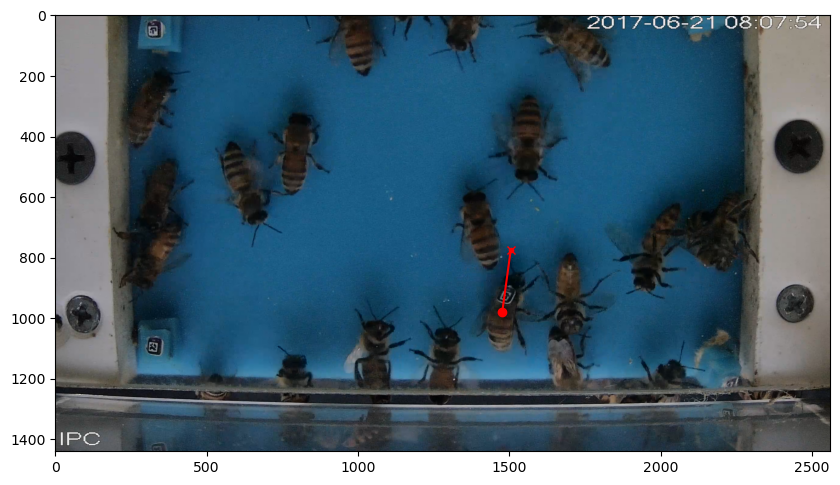

In [21]:
# Visualize one event manually
%matplotlib inline

#event = full_df.iloc[10]
event = full_df.loc[3606]

with pd.option_context('display.max_colwidth', 200):
    display(pd.DataFrame(event))

fig = plt.figure(figsize=(10,6))
frame = event.track_startframe
plot_track(event, frame=frame, videoreader=None, ax=None);

## Manual display of one event with frame navigation

interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', max=10000), IntSlider(v…

<function __main__.show_frame(frame, resolution_level)>

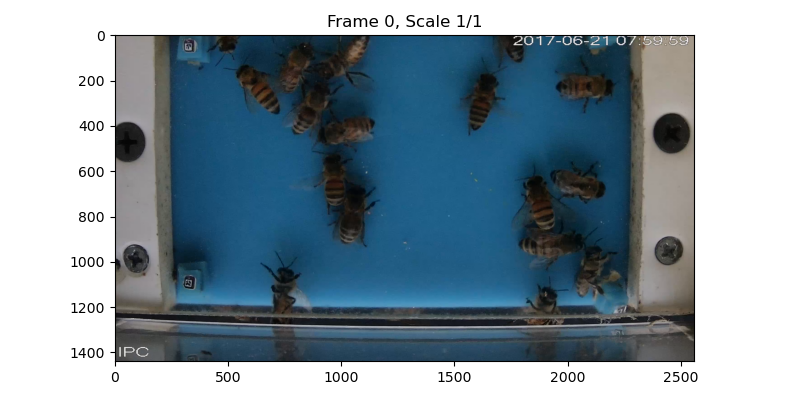

In [22]:
# Example of faster GUI to plot images
%matplotlib widget
from ipywidgets import *
#from skimage.transform import resize, rescale
import PIL

# Pick up event to display
event = vdf.iloc[0]


# Create sliders
frame_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0, continuous_update=False)
scale_slider = widgets.IntSlider(min=0, max=6, step=1, value=0, continuous_update=False)

# Open video
vr = VideoReader(event['video_filename'], ctx=cpu(0))


def imscale(img, s):
    h,w,_ = img.shape
    return np.asarray(PIL.Image.fromarray(img).resize((int(w * s), int(h * s))))

# Create one figure for all display
plt.rcParams['figure.figsize'] = [10, 10]
fig = plt.figure(figsize=(8,4))
fig.set_tight_layout(True)
fig.canvas.header_visible = False
ax = fig.add_subplot(111)
# Initialize plot to set the image extent
frame = event['track_startframe']
#frame=0
frameimg = vr[frame].asnumpy()
ax.clear()
ax.imshow(imscale(frameimg, 1.0))
ax.set_title(f"{frame}")

def show_frame(frame, resolution_level):
    # Load image
    frameimg = vr[frame].asnumpy()
    scale = 2**resolution_level
    frameimg = imscale(frameimg, 1.0/scale)
    
    # Alternate method: reset the whole axes
    #ax.clear()
    #ax.imshow(frameimg)
    # Replace image data (keep same axis extent)
    ax.images[0].set_data( frameimg )
    ax.set_title(f"Frame {frame}, Scale 1/{scale}")
    #fig.canvas.draw()
    
interact(show_frame, frame=frame_slider, resolution_level=scale_slider)

## Selection of events from vdf dataframe

In [49]:
def event_name(row):
    noise = False
    event_name = ""
    if row.pollen:            event_name += "pollen"
    if row.entering:          event_name += "entering"
    if row.leaving:           event_name += "leaving"
    if row.walking:           event_name += "walking"
    if row.entering_leaving:  event_name += "entering_leaving"
    if event_name == "":
        event_name += "noise"
        noise = True
        
    event_name += " - {}".format(row.datetime)
    return noise, event_name

In [48]:
%matplotlib widget
from ipywidgets import *
from collections import namedtuple
import time
from functools import lru_cache
#from skimage.transform import resize, rescale
import PIL

# vdf must be defined previously

# Create one figure
plt.ioff()
fig = plt.figure(figsize=(8,4))
plt.ion()
fig.canvas.header_visible = False
fig.clear()
ax = fig.add_subplot(111)
ax.clear()
ax.imshow(np.array([[0,1]]))
ax.set_title(f"Initialized")
fig.set_tight_layout(True)

from dataclasses import dataclass

@dataclass
class Glob:
    vr = None

glob = Glob()

def get_event_options(vdf, tid):
    options = list()
    for i, row in vdf[vdf.track_tagid == tid].iterrows():
        noise, name = event_name(row)
#         if not noise:
        D = dict(row)
        D['loc']=i
        options.append((name, D))
    return options

# Widgets
tids_widget = Dropdown(options = tids)
options = get_event_options(vdf, tids_widget.value)
events_widget = Dropdown(options=options)
frame_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0, continuous_update=False)
scale_widget = Dropdown(options=[0,1,2,3,4,5,6])

debug_view = widgets.Output(layout=Layout(height='200px', overflow_y='auto'))
event_view = widgets.Output(layout=Layout(height='400px', max_width='600px', overflow_x='auto', overflow_y='auto'))


@lru_cache(maxsize=20)
def get_frame(frame):
    img = glob.vr[frame].asnumpy()
    glob.vr.seek(0)
    return img

def imscale(img, s):
    h,w,_ = img.shape
    return np.asarray(PIL.Image.fromarray(img).resize((int(w * s), int(h * s))))
        
def debug(clear_output=False):
    def wrapped_fun(fn):
        def wraps(*args, **kwargs):
            with debug_view:
                if (clear_output):
                    debug_view.clear_output()
                fn(*args, **kwargs)
        return wraps
    return wrapped_fun

@debug(clear_output=True)
def tid_changed(change):
    ctid = change.new
    print('tid_changed',ctid)
    options = get_event_options(vdf, ctid)
    events_widget.options = options

@debug()
def event_changed(change):
    event = change.new
    print('event_changed',event)
    
    eventrow = vdf.loc[event['loc']]
    
    with event_view:
        event_view.clear_output()
        with pd.option_context('display.max_colwidth', 200):
            display(pd.DataFrame(eventrow))
            print(eventrow['video_filename'])

    print('LOADING VIDEO...')
    tic = time.perf_counter()
    glob.vr = VideoReader(event['video_filename'], ctx=cpu(0))
    toc = time.perf_counter()
    print(f'LOADED. ({toc-tic:.2f}s)')
    glob.vr.seek(0)
    get_frame.cache_clear()
    
    ax.clear()

    #frameimg = glob.vr[0].asnumpy()
    #ax.imshow(imscale(frameimg*0, 1.0)) # Dummy
    
    frame = event["track_startframe"]
    frame_slider.min = -10000
    frame_slider.max = frame+100
    frame_slider.min = frame-100
    frame_slider.value = frame
    
    redraw()

@debug()
def frame_changed(change):
    frame = change.new
    print('frame_changed',frame)
    redraw()

@debug()
def redraw(change=None):
    event, frame = events_widget.value, frame_slider.value
    #print(event, frame)
    resolution_level = scale_widget.value
    scale = 2**resolution_level
    
    print('REDRAW', frame, resolution_level)
    loc = event['loc']
    
    #plot_track(event, frame, vr, ax)
    tic = time.perf_counter()
    frameimg = get_frame(frame)
    toc = time.perf_counter()
    print(f'TOOK {toc-tic:.2f}s')

    if len(ax.images)==0:
        ax.clear()
        ax.imshow(imscale(frameimg, 1.0/scale), extent=[0,frameimg.shape[1],frameimg.shape[0],0])
        #ax.plot([0,3],[6,4],'r-')

        # OVERLAY TRACK BEGIN/END
        start_x = event["track_startx"] 
        start_y = event["track_starty"]
        end_x = event["track_endx"]
        end_y = event["track_endy"]

        #ax.plot( (start_x,end_x), (start_y,end_y), 'r.-' )
        #ax.plot( (start_x,), (start_y,), 'ro' )
        #ax.plot( (end_x,), (end_y,), 'rx' )
        #ax.text( start_x,start_y, 'S', color='red', fontsize=24.0, horizontal_alignemnt='center' )
        ax.arrow( start_x, start_y, end_x-start_x, end_y-start_y, color='red', length_includes_head=True, head_width=40.0 )
    else:
        ax.images[0].set_data( imscale(frameimg, 1.0/scale) )
    ax.set_title(f"Event {loc}, Frame {frame}")
    
    #fig.canvas.draw()
    
#interact(f, tid=tids_widget, event=events_widget, frame=frame_slider);

tids_widget.observe(tid_changed, names="value")
events_widget.observe(event_changed, names="value")
frame_slider.observe(frame_changed, names="value")
scale_widget.observe(redraw, names="value")

scene = VBox([ 
                HBox([tids_widget, events_widget]),
                HBox([frame_slider, scale_widget]),
                HBox([VBox([fig.canvas], layout=Layout(border='1px solid black', width='100%',overflow_x='auto',overflow_y='auto')), 
                      VBox([event_view], layout=Layout(border='1px solid black', width='100%',overflow_x='auto',overflow_y='auto')) ]),
                HBox([debug_view], layout=Layout(border='1px solid black'))
             ], layout=Layout(width='100%',overflow_x='auto'))
display(scene)

from traitlets.utils.bunch import Bunch
tid_changed(Bunch(new=tids[0]))
event_changed(Bunch(new=events_widget.options[0][1]))